In [815]:
from argparse import ArgumentParser
from sklearn.preprocessing import SplineTransformer
from collections import OrderedDict
from torch import nn
import torch
import torch.nn.functional as F
import math
import numpy as np


def sim_data(n, dim, Type):
	if Type == 'A':
		X = torch.rand((n,dim))
		y = torch.exp(2*torch.sin(X[:,0]*0.5*torch.pi)+ 0.5*torch.cos(X[:,1]*2.5*torch.pi))
		y = y.reshape(-1,1)
		y = y.float()
		
	elif Type == 'B':
		X = torch.rand((n, dim))
		y = 1
		for d in range(dim):
			a = (d+1)/2
			y *= ((torch.abs(4*X[:,d]-2)+a)/(1+a))
		y = y.reshape(-1,1)
		y = y.float()
	else:
		pass
	
	return X, y
	
def norm(x):
	return (x-torch.min(x))/(torch.max(x)-torch.min(x))


class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def diag_mat_weights(dimp, type = 'first'):
	if type == 'first':
		dg = np.zeros((dimp-1, dimp))
		for i in range(dimp-1):
			dg[i,i] = -1
			dg[i,i+1]= 1
	elif type == 'second':
		dg = np.zeros((dimp-2, dimp))
		for i in range(dimp-2):
			dg[i,i] = -1
			dg[i,i+1]= 2
			dg[i,i+2]= -1
	else:
		pass
	return torch.Tensor(dg)

def num_para(model):
	tp = 0
	for param in model.parameters():
		tp += param.numel()
	return tp


## ECM

In [816]:
def ECM(par, initial_xi = 1, initial_sigma = 1, initial_lambda = 1e-4):
    lambdab = initial_lambda
    sigma = initial_sigma
    xi = initial_xi
    
    n_block, num_knots, num_neurons = par['wbasic'].size()
    ls_lambda = torch.empty(n_block)
    
    for l in range(n_block):
        B = par['ebasic'][l]
        By = par['basic'][l]
        WB = par['wbasic'][l]
        
        DB = diag_mat_weights(WB.size()[0]).to(device)
        size = B.size()[1]
        S = DB.T @ DB
        Cov_a = (xi**2)* torch.linalg.pinv(S)
        Cov_e = torch.eye(size*num_neurons)* sigma
        
        block_y = torch.reshape(By, (-1,1))
        flatB = B.view(num_neurons, num_knots, size)
            
        sqr_xi= 0
        sqr_sig = 0
        
        for i in range(num_neurons):
            Ncov = (Cov_a -(Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)]) @ flatB[i].T @ Cov_a))
            Nmu = (Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)])) @ By[:,i].reshape(-1,1)
            
            first_xi = S @ Ncov
            second_xi = (Nmu.T @ S @ Nmu)
            sqr_xi += torch.trace(first_xi) + second_xi
                
            first_sig = torch.norm(By[:,i])
            second_sig = 2 * (By[:,i] @ flatB[i].T) @ Nmu 
            third_sig = torch.trace((flatB[i] @ flatB[i].T) @ Ncov)
            four_sig = (Nmu.T @ flatB[i] @ flatB[i].T @ Nmu)
            
            sqr_sig += (first_sig + second_sig + third_sig + four_sig)
        
        sqr_xi /= num_neurons
        sqr_sig /= (num_neurons*size)
        
        ls_lambda[l] = (sqr_sig/sqr_xi).item()
    
    return ls_lambda

## Model

In [817]:
class BSL(nn.Module):
    def __init__(self, degree, num_knots, num_neurons, bias = True):
        super(BSL, self).__init__()
        self.degree = degree
        self.num_knots = num_knots
        self.num_neurons = num_neurons
        self.control_p = nn.Parameter(torch.randn(self.num_knots, self.num_neurons))
        
        if bias:
            self.bias = nn.Parameter(torch.randn(self.num_neurons))
        else:
            self.register_parameter('bias', None)
            
        self.inter = {}
    
    def basis_function(self, x, i, k, t):
    
        # Base case: degree 0 spline
        if k == 0:
            return ((t[i] <= x) & (x < t[i + 1])).float()
    
        # Recursive case
        denom1 = t[i + k] - t[i]
        denom2 = t[i + k + 1] - t[i + 1]
    
        term1 = 0
        if denom1 != 0:
            term1 = (x - t[i]) / denom1 * self.basis_function(x, i, k - 1, t)
    
        term2 = 0
        if denom2 != 0:
            term2 = (t[i + k + 1] - x) / denom2 * self.basis_function(x, i + 1, k - 1, t)
    
        return term1 + term2

    def knots_distribution(self, dg, nk):

        knots = torch.cat([torch.linspace(-0.002, -0.001, steps=dg),            # Add repeated values at the start for clamping
            torch.linspace(0, 1, nk-2*dg-2),  # Uniform knot spacing in the middle
            torch.linspace(1.001, 1.002, steps=dg)           # Add repeated values at the end for clamping
            ]).view(-1,1)
     
        return knots
    
    def basis_function(self, x, spl):
        basis_output = spl.fit_transform(x)
        return basis_output
            
    def forward(self, x):
        batch_size, num_features = x.size()
        device = x.device
        
        # Create knot vector and apply B-spline basis functions for each feature
        basises = []
        knots = self.knots_distribution(self.degree, self.num_knots)
        knots = knots.to(device)
        spl = SplineTransformer(n_knots=self.num_knots, degree=self.degree, knots = knots)

        
        for feature in range(num_features):
            # Calculate B-spline basis functions for this feature
            
            basis = self.basis_function(x[:, feature].reshape(-1,1), spl)
            basis = torch.Tensor(basis)
            basises.append(basis)

        if num_features == 1:
            tout = basises[0] @ self.control_p
            self.inter['basic'] = basises[0].T
        else:
            self.inter['basic'] = torch.reshape(torch.stack(basises, dim = 1), (batch_size, self.num_knots * self.num_neurons)).T
            basises = torch.stack(basises)
            tout = basises.permute(1,2,0) * self.control_p
            tout = tout.sum(dim =1)
                
        if self.bias is not None:
            tout += self.bias        
            
        return tout


class NormLayer(nn.Module):
	def __init__(self):
		super(NormLayer, self).__init__()

	def forward(self, x):
		min_val = torch.min(x, axis = 1).values.reshape(-1,1)
		max_val = torch.max(x, axis = 1).values.reshape(-1,1)

		x = (x - min_val)/(max_val - min_val)  # Rescale to [0, 1]
		return x.detach()

In [818]:
class BSpline_block(nn.Module):
    def __init__(self, degree, num_knots, num_neurons, dropout = 0.0, bias = True):
        super(BSpline_block, self).__init__()

        self.block = nn.Sequential(OrderedDict([
            ('norm', NormLayer()),
            ('BSL', BSL(degree = degree, num_knots = num_knots, num_neurons = num_neurons, bias = bias)),
            ('drop', nn.Dropout(dropout)),
        ]))
        
    def forward(self, x):
        return self.block(x)
        
class StackBS_block(nn.Module):
    def __init__(self, block, degree, num_knots, num_neurons, num_blocks, dropout = 0.0, bias = True):
        super().__init__()
        self.model = nn.ModuleDict({
            f'block_{i}': block(degree = degree, num_knots = num_knots, num_neurons = num_neurons)
            for i in range(num_blocks)
        })

    def forward(self, x):
        for name, block in self.model.items():
            x = block(x)
        return x

In [819]:

class DPS(nn.Module):
    def __init__(self, input_dim, degree, num_knots, num_neurons, num_bsl, output_dim, bias):
        super(DPS, self).__init__()
        self.num_neurons = num_neurons
        self.num_knots = num_knots
        self.ln1 = nn.Linear(input_dim, num_neurons)
        #self.nm1 = NormLayer() 
        #self.sp1 = BSL(degree = degree, num_knots = num_knots, num_neurons = num_neurons, bias = True)
        self.Spline_block = StackBS_block(BSpline_block, degree = degree, num_knots = num_knots, num_neurons = num_neurons, num_blocks = num_bsl)
        self.ln2 = nn.Linear(num_neurons, output_dim)
        #self.inter = {}
        
    def forward(self, x):
        
        x = self.ln1(x)

        # # # # # # # # # # # # # #
        #          SPLINE         #
        # # # # # # # # # # # # # #
        
        spout = self.Spline_block(x)

        '''  
        ln1out = self.nm1(ln1out)
        device = ln1out.device
        batch_size, _ = x.size()
        
        # # # # # # # # # # # # # #
        #          SPLINE         #
        # # # # # # # # # # # # # #
        
        sp1out = self.sp1(ln1out)
        bslist = self.sp1.inter['basic']
        
        self.inter['ebasic'] = bslist
        self.inter['basic'] = sp1out
        '''
        
        output = self.ln2(spout)
        
        return output

    def get_para_ecm(self, x):

        '''
        ecm_para: A dictionary that collects the parameter we need to the following ECM algorithm.
        ecm_para.basic: Store the output of each B-Spline block; Dimension = [n_sample, n_neurons]
        ecm_para.ebasic Store the weight matrix of each B-Spline expansion; Dimension = [n_knots * n_neurons, n_sample]

        '''
        ecm_para = {}
        bs_block_out = {}
        bs_spline_weight = {}
        bs_spline_value = {}
        bs_spline_bias = {}

        _ = self(x)
        
        def get_activation(name):
            def hook(model, input, output):
                bs_block_out[name] = output.detach()
            return hook

        handles = []
        for name, layer in self.named_modules():
            if 'block.drop' in name:
                handles.append(layer.register_forward_hook(get_activation(name)))
            elif 'block.BSL' in name:
                bs_spline_value[name] = layer.inter['basic'].detach()
                bs_spline_weight[name] = layer.control_p.detach()
                bs_spline_bias[name] = layer.bias.detach()
        # Run forward pass (triggers hooks)
        _ = self(x)

        # Clean up hooks
        for h in handles:
            h.remove()
            
        ecm_para['basic'] = torch.stack(list(bs_block_out.values()), dim=0)
        ecm_para['ebasic'] = torch.stack(list(bs_spline_value.values()), dim=0)
        ecm_para['wbasic'] = torch.stack(list(bs_spline_weight.values()), dim=0)
        ecm_para['bbasic'] = torch.stack(list(bs_spline_bias.values()), dim=0)
        del bs_block_out, bs_spline_weight, bs_spline_value, bs_spline_bias
        
        return ecm_para

    def fit(self, x):
        return 0

## Data Preprocessing

In [820]:
ntrain = 800; ntest = 2500; ndim = 2; ndf = 1; nk = 15; nm = 50; Fout = 1
Dtype = 'A'
data = {}
torch.manual_seed(0)

for d in range(ndf):
    X_train, y_train = sim_data(ntrain, ndim, Dtype)
    X_test, y_test = sim_data(ntest, ndim, Dtype)
    epstrain = torch.normal(0, torch.var(y_train)*0.05, size=y_train.size())
    epstest = torch.normal(0,  torch.var(y_train)*0.05, size=y_test.size())
    
    y_train, y_test = y_train + epstrain, y_test + epstest
    data[str(d+1)] = {'TrainX': X_train, 'Trainy': y_train, 'TestX': X_test, 'Testy': y_test}
    
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion = torch.nn.MSELoss(reduction='mean')

## Training

In [821]:
DeepBS = DPS(input_dim = ndim, degree = 3, num_knots = nk, num_neurons = nm, num_bsl = 2, output_dim = Fout, bias = True).to(device)
learning_r = 1e-1
optimizer = torch.optim.Adam(DeepBS.parameters(), lr=learning_r)
Iteration = 10000; bloss_list = []; tor = 1e-5; lr_tor = 1e-6
patientc = 30; patientr = 10; tpat = 0; bloss = 9999

In [822]:
for t in range(Iteration):
    # Forward pass: Compute predicted y by passing x to the modelsp
    pyb_af = DeepBS(X_train)
    loss = criterion(y_train, pyb_af); bloss_list.append(loss.item())
    
    if (t > 0) and ((bloss_list[t-1]-bloss_list[t])<tor):        
        if (tpat != 0) and (tpat % patientr) == 0:
            learning_r *= 0.2 
            tpat += 1
            #print('Learning rate reduce to ', learning_r)
            optimizer = torch.optim.Adam(DeepBS.parameters(), lr=learning_r)
            if learning_r <= lr_tor:
                if t < patientc + 1:
                    conv = False
                else:
                    conv = True
                print('Convergence!')
                break
        elif tpat < patientc:
            tpat += 1
            pass
        else:
            if t < patientc + 1:
                conv = False
            else:
                conv = True
            print('Convergence!')
            break
        
    else:
        if loss < bloss:
            print('Current loss: ', loss.item(), ' | , previous best loss: ', bloss, ' | saving best model ...')
            torch.save(DeepBS.state_dict(), './EXA'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk)+'data'+str(d+1))
            bloss = loss.item()
            tpat = 0
        else:
            tpat += 1
    
    if tpat == patientc:
        if t < patientc + 1:
            conv = False
        else:
            conv = True
            print('Convergence!')
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Current loss:  39.23202896118164  | , previous best loss:  9999  | saving best model ...
Current loss:  10.675946235656738  | , previous best loss:  39.23202896118164  | saving best model ...
Current loss:  8.817166328430176  | , previous best loss:  10.675946235656738  | saving best model ...
Current loss:  7.756436824798584  | , previous best loss:  8.817166328430176  | saving best model ...
Current loss:  5.437385082244873  | , previous best loss:  7.756436824798584  | saving best model ...
Current loss:  5.335794448852539  | , previous best loss:  5.437385082244873  | saving best model ...
Current loss:  4.226558208465576  | , previous best loss:  5.335794448852539  | saving best model ...
Current loss:  3.3025193214416504  | , previous best loss:  4.226558208465576  | saving best model ...
Current loss:  2.9383482933044434  | , previous best loss:  3.3025193214416504  | saving best model ...
Current loss:  2.4671576023101807  | , previous best loss:  2.9383482933044434  | saving b

## ECM-Fine Tuning

### Via ECM to implement layer-wise optimization for tuning the weight for B-Spline Block

In [694]:
DeepPS = DPS(input_dim = ndim, degree = 3, num_knots = nk, num_neurons = nm, num_bsl = 2, output_dim = Fout, bias = True).to(device)
DeepPS.load_state_dict(torch.load( './EXA'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk)+'data'+str(d+1), weights_only = True))

#DPSy = DeepPS(X_train)
#ECM_para = DeepPS.get_para_ecm(X_train)
#ECM_Lambda = ECM(ECM_para, initial_xi = 1, initial_sigma = 1, initial_lambda = 1e-4)

<All keys matched successfully>

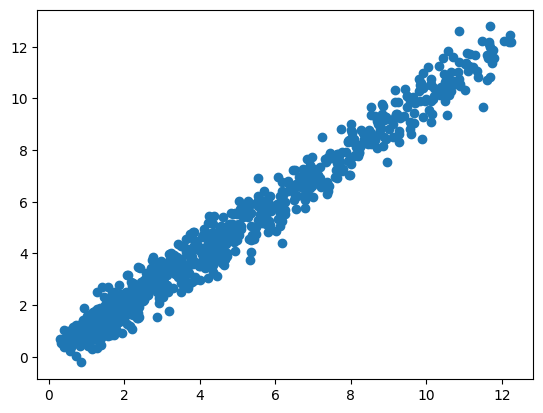

In [695]:
plt.scatter(DeepPS(X_train).detach().numpy(), y_train.detach().numpy())

In [804]:
def ECM(par, initial_xi = 1, initial_sigma = 1, initial_lambda = 1e-4):
    lambdab = initial_lambda
    sigma = initial_sigma
    xi = initial_xi
    
    n_block, num_knots, num_neurons = par['wbasic'].size()
    ls_lambda = torch.empty(n_block)
    
    for l in range(n_block):
        B = par['ebasic'][l]
        By = par['basic'][l]
        WB = par['wbasic'][l]
        
        DB = diag_mat_weights(WB.size()[0]).to(device)
        size = B.size()[1]
        S = DB.T @ DB
        Cov_a = (xi**2)* torch.linalg.pinv(S)
        Cov_e = torch.eye(size*num_neurons)* sigma
        
        block_y = torch.reshape(By, (-1,1))
        flatB = B.view(num_neurons, num_knots, size)
            
        sqr_xi= 0
        sqr_sig = 0
        
        for i in range(num_neurons):
            Ncov = (Cov_a -(Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)]) @ flatB[i].T @ Cov_a))
            Nmu = (Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)])) @ By[:,i].reshape(-1,1)
            
            first_xi = S @ Ncov
            second_xi = (Nmu.T @ S @ Nmu)
            sqr_xi += torch.trace(first_xi) + second_xi
                
            first_sig = torch.norm(By[:,i])
            second_sig = 2 * (By[:,i] @ flatB[i].T) @ Nmu 
            third_sig = torch.trace((flatB[i] @ flatB[i].T) @ Ncov)
            four_sig = (Nmu.T @ flatB[i] @ flatB[i].T @ Nmu)
            
            sqr_sig += (first_sig + second_sig + third_sig + four_sig)

        sqr_xi /= num_neurons
        sqr_sig /= (num_neurons*size)

        print(sqr_xi, sqr_sig)
        ls_lambda[l] = (sqr_sig/sqr_xi).item()
    
    return ls_lambda
    
def ECM_layersise_update(model, par, Lambda, x, y):

    model.eval()
    with torch.no_grad():
        DSy = model(x)
        print('Training Error: ', np.round(criterion(y, DSy.detach()).item(), 5))
              
    B_out, B_in, B_w, B_b = par['basic'], par['ebasic'], par['wbasic'], par['bbasic']
    n_layer, nk, nm = B_w.size()
    DB = diag_mat_weights(B_w[0].size()[0], 'second').to(device)

    Project_matrix = (torch.linalg.pinv(B_in[-1].T @ B_in[-1]) @ B_in[-1].T @ B_in[-1])
    Size = [b.size()[1] for b in B_in]

    B_in = B_in.view(n_layer, nm, nk, Size[0])
    
    for l in range(n_layer):    
        NW = torch.empty((nk, nm))
        NB = torch.empty((nm))
        
        for i in range(nm):
            B1y = B_out[l][:,i] - B_b[l][i]
            BB = B_in[l][i].T
    
            # Update the weights and bias
            NW[:, i] = (torch.inverse(BB.T @ BB + (Lambda[l]/Size[l]) * (DB.T @ DB)) @ BB.T @ B1y)
            NB[i] = torch.mean(B_out[l][:,i] - (NW[:,i] @ BB.T))
                
        # update the weight
        block = getattr(model.Spline_block.model, f'block_{l}')
        getattr(block.block.BSL, 'control_p').data = NW
        getattr(block.block.BSL, 'bias').data = NB

    
    with torch.no_grad():
        DPSy = model(x)
        Update_Train_Loss = np.round(criterion(y, DPSy.detach()).item(), 5)
        GCV = np.round((torch.norm(y - DPSy)/(Size[-1]-torch.trace(Project_matrix))).item(), 5)
    
    return model, GCV

In [799]:
## Initialization
model = DPS(input_dim = ndim, degree = 3, num_knots = nk, num_neurons = nm, num_bsl = 2, output_dim = Fout, bias = True).to(device)
model.load_state_dict(torch.load( './EXA'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk)+'data'+str(d+1), weights_only = True))

BestGCV = 9999
for i in range(10):
    _ = model(X_train)
    ECM_para = model.get_para_ecm(X_train)
    ECM_Lambda = ECM(ECM_para, initial_xi = 1, initial_sigma = 1, initial_lambda = 1e-4)

    print('Lambda: ', ECM_Lambda)
    model, GCV = ECM_layersise_update(model, ECM_para, ECM_Lambda, X_train, y_train)

    if GCV < BestGCV:
        BestLambda = ECM_Lambda
        BestGCV = GCV

0.24466666666666667

### Fast-Tuning for optimimal DPS parameter

## Evaluation on DS and DPS

In [ ]:
with torch.no_grad():
    eval_model = DPS(input_dim = ndim, degree = 3, num_knots = nk, num_neurons = nm, num_bsl = 1, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load( './EXA'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk)+'data'+str(d+1), weights_only = True))
    DPSy = eval_model(X_train)
    LambdaB = ECM(model = eval_model, num_neurons = nm, num_knots = nk)
    Lambdalist[str(d+1)] = LambdaB